## Final Project Submission

Please fill out:
* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time: 3:00PM EST, 9/6/23
* Instructor name: Morgan Jones
* Blog post URL: https://medium.com/@abbycampbell0/a-brief-and-incomplete-history-of-ai-468845a93b24


# Business Problem

This company has decided to create a new movie studio, but they don’t know much about creating movies. Before investing in a large movie project, they need to know which types of movies are doing well, which directors perform well within a reasonable budget, and which time of year is best to release. The results of this project are summarized in a presentation suitable to be presented to a non-techinical audience and translated to make clear business recommendations.

## The Data

In the folder zippedData are movie datasets from:s

- Box Office Mojo
- IMDB
- Rotten Tomatoes
- TheMovieDB
- The Numbers

Data from IMDB is located in a SQLite database.

The primary data sets used in the investigation were the IMDB SQL database, as well as the The Numbers data set. These data sets were combined to get box office and budget information for specific movies and genres, as well as box office and budget information for specific directors, as well as their ratings.

# Setup

### Import relevant packages

In [1]:
import sqlite3 
import pandas as pd
import numpy as np
import zipfile
import scipy.stats as stats
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load and Clean Data

### Movie Info

1552 entries after filtering

Remove columns: currency, writer, runtime, synopsis, dvd_date

runtime note: value = integers, but each integer is followed by 'minutes'

dates note: given as month day, year format

    - month is in the three letter format
    - day is given as 1 or 2 digits (does not put a 0 in from on single digit days)
    - year is alwasy 4 digits
    
Genres given as a list in a single string

In [2]:
# load data
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', thousands=',')

# drop columns that are irrelevent
movie_info = movie_info.drop(['currency', 'writer', 'runtime', 'synopsis', 'dvd_date'], axis=1)

# remove NaN rows for genre
movie_info = movie_info.dropna(axis=0, subset=['genre'])

# separate genre into a list of genres
movie_info['genre'] = movie_info['genre'].map(lambda x: x.split('|'))

### Reviews

40915 entries after filtering

Review format = rating/total possible

Fresh = fresh and rotten are the only two values - will probably use this as the rating metric

Date: given as month day, year format
- month is in the three letter format
- day is given as 1 or 2 digits (does not put a 0 in from on single digit days)
- year is alwasy 4 digits

In [3]:
# load data
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='unicode_escape')

# convert fresh column to 0 (rotten) or 1 (fresh)
reviews['fresh_rating'] = reviews['fresh'].map(lambda x: 0 if 'rotten' in x else 1)

# remove all rows with no rating
reviews = reviews.dropna(axis=0, subset=['rating'])

reviews.info()
# reviews['fresh_rating'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40915 entries, 0 to 54431
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            40915 non-null  int64 
 1   review        35379 non-null  object
 2   rating        40915 non-null  object
 3   fresh         40915 non-null  object
 4   critic        38935 non-null  object
 5   top_critic    40915 non-null  int64 
 6   publisher     40688 non-null  object
 7   date          40915 non-null  object
 8   fresh_rating  40915 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 3.1+ MB


### Budgets

5792 entries after filtering

The budget and gross columns contain a dollar sign at the beginning of the value, as well as columns to separate out thousands.

    - remove dollar sign
    - remove commas
    - convert to integer

drop any entires with now movie title

In [4]:
# load data
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', thousands=',')

# format the money columns to be integers, without the $ sign
budgets = budgets.drop(['id'], axis=1)
budgets['production_budget'] = budgets['production_budget'].map(lambda x: int(x[1:].replace(',', '')))
budgets['domestic_gross'] = budgets['domestic_gross'].map(lambda x: int(x[1:].replace(',', '')))
budgets['worldwide_gross'] = budgets['worldwide_gross'].map(lambda x: int(x[1:].replace(',', ''))) 

# drop any moves with no title
budgets = budgets.dropna(subset=['movie'])

budgets = budgets.rename(columns={'movie': 'title'})
# budgets = budgets.set_index('title')

# calculate roi
budgets['domestic_roi'] = budgets['domestic_gross']/budgets['production_budget']
budgets['worldwide_roi'] = budgets['worldwide_gross']/budgets['production_budget']
len(budgets)

5782

### SQL IMDB Database

In [5]:
# unzip imdb
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('zippedData')
    
# create connection to the SQL database
conn = sqlite3.connect('zippedData/im.db')

#### Movie Info

140,734 entries after filtering

    - filtered to only include moves released after 1980 (to only look at movies relevant to recent trends)
    - filtered out any entries with no movie title or genre
    
split the genre column up into a list of individual genres, rather than a string containing all

In [6]:
# table containing move title, id, start_year, and genres
# remove all lines without the genre

sql_movie_basics = pd.read_sql("""
                                SELECT movie_id, original_title, start_year, genres
                                    FROM movie_basics
                                """, conn)

# remove movies with no title
sql_movie_basics = sql_movie_basics.dropna(subset=['original_title'])

# remove movies before 1980 (trying to stay modern)
sql_movie_basics = sql_movie_basics[sql_movie_basics['start_year'] >= 1980]

# rename title column, drop all rows with no genre information
sql_movie_basics = sql_movie_basics.rename(columns={'original_title': 'title'})
sql_movie_basics = sql_movie_basics.dropna(axis=0, subset=['genres'])

# split the genres string into a list of individual genres
sql_movie_basics['genres'] = sql_movie_basics['genres'].map(lambda x: x.split(','))
sql_movie_basics['count'] = 1
sql_movie_basics.to_csv('data/sql_movie_basics.csv')
sql_movie_basics

,movie_id,title,start_year,genres,count
0,tt0063540,Sunghursh,2013,"[Action, Crime, Drama]",1
1,tt0066787,Ashad Ka Ek Din,2019,"[Biography, Drama]",1
2,tt0069049,The Other Side of the Wind,2018,[Drama],1
3,tt0069204,Sabse Bada Sukh,2018,"[Comedy, Drama]",1
4,tt0100275,La Telenovela Errante,2017,"[Comedy, Drama, Fantasy]",1
...,...,...,...,...,...
146138,tt9916428,The Secret of China,2019,"[Adventure, History, War]",1
146139,tt9916538,Kuambil Lagi Hatiku,2019,[Drama],1
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,[Documentary],1
146141,tt9916706,Dankyavar Danka,2013,[Comedy],1


#### Directors

69,772 entries after filtering

    - a movie with multiple directors will have multiple rows (one per director)

match movie titles to their director using the person and movie ids provided in the database

only include movies/directors with more than 10 votes in their rating to ensure that we are getting movies and directors with a wider reach

In [7]:
# import directors of movies with more than 10 reviews (to ensure we get movies with some reach)
director_table = pd.read_sql("""
    SELECT m.primary_title, p.primary_name, r.averagerating, r.numvotes
        FROM movie_basics as m
        JOIN directors as d
            ON m.movie_id = d.movie_id
        JOIN persons as p
            USING(person_id)
        JOIN movie_ratings as r
            USING(movie_id)
        WHERE numvotes > 10
    """, conn)
# drop any duplicate entires
director_table = director_table.drop_duplicates(keep='last')

# rename title column to just title - make all movie title columns univorm
director_table = director_table.rename(columns={'primary_title': 'title'})

director_table.to_csv('data/director_table.csv')
director_table

,title,primary_name,averagerating,numvotes
1,Laiye Je Yaarian,Sukh Sanghera,8.3,31
2,Borderless,Caolan Robertson,8.9,559
3,Borderless,George Llewelyn-John,8.9,559
4,Just Inès,Marcel Grant,6.4,20
8,The Legend of Hercules,Renny Harlin,4.2,50352
...,...,...,...,...
155471,Plugged in,Richard Willett,8.6,27
155472,Caisa,Alexandru Mavrodineanu,8.1,25
155474,Code Geass: Lelouch of the Rebellion - Glorifi...,Gorô Taniguchi,7.5,24
155475,Sisters,Prachya Pinkaew,4.7,14


# Combine tables to get the specific metrics

## Combine budgets table and movie info table

Create new colulmns containing the release year and the release month

Since there are several movies released under the same name, only keep the entries where the release year and the start year are within 1 year of each other. If there are still duplicate entries under the same title, drop them, since there is no way of determining which movie the budget data belongs to.

after dropping duplicates, the number of movies there is data for drops from 3473 to 2253.

In [8]:
budgets_basics = budgets.merge(sql_movie_basics, left_on='title', right_on='title')

# add a realase month and release year column
budgets_basics['release_year'] = budgets_basics['release_date'].map(lambda x: int(x[-4:]))
budgets_basics['release_month'] = budgets_basics['release_date'].map(lambda x: x[0:4])

# only keep the movies that line up with their start year and release year (deal with duplicates)
# budgets_basics_2 = budgets_basics[(budgets_basics["release_year"] - budgets_basics["start_year"] <= 1) & (budgets_basics["release_year"] > budgets_basics["start_year"])].copy()
budgets_basics.to_csv('data/budgets_basics.csv')

# set title column name to just title - keep all title columns uniform
budgets_basics = budgets_basics.set_index('title')

# remove any duplicate titles - will be hard to combine with other tables when we are using the title as the point of comparison
budgets_basics = budgets_basics[~budgets_basics.index.duplicated()]

print(len(budgets_basics))

2253


### organize by genre

Since the genres are listed in a single string (e.g. 'Comedy, Action, Adventure'), they need to be separated into a list of individual genres the movies can be organized by the base genres.

In [9]:
# separate out the genre column into one row for each individual genre
split_genres = budgets_basics.explode('genres')
split_genres.to_csv('data/split_genre.csv')

get the sum and mean aggregations, then combine them so as to include average gross earnings and budget data as well as the total data for that genre. 

add new columns calculating the domestic and worldwide ROIs

In [10]:
# get aggregations for genre information
genre_roi = split_genres.groupby('genres').mean()
genre_roi_sum = split_genres.groupby('genres').sum()
genre_roi['count'] = genre_roi_sum['count']
genre_roi['total_domestic_gross'] = genre_roi_sum['domestic_gross']
genre_roi['total_worldwide_gross'] = genre_roi_sum['worldwide_gross']

# recalc rois
genre_roi['domestic_roi'] = genre_roi['domestic_gross']/genre_roi['production_budget']
genre_roi['worldwide_roi'] = genre_roi['worldwide_gross']/genre_roi['production_budget']

genre_roi.to_csv('data/genre_roi.csv')
genre_roi.describe()

,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,start_year,count,release_year,total_domestic_gross,total_worldwide_gross
count,2.100000e+01,2.100000e+01,2.100000e+01,21.000000,21.000000,21.000000,21.000000,21.000000,2.100000e+01,2.100000e+01
mean,3.998325e+07,4.891433e+07,1.209342e+08,1.278929,2.957526,2013.870849,249.809524,2010.982861,1.211876e+10,3.025205e+10
std,2.491352e+07,2.902721e+07,8.757421e+07,0.278359,0.643543,0.485888,258.228507,2.213178,1.320875e+10,3.534494e+10
min,1.592538e+07,2.411895e+07,4.881133e+07,0.772692,1.669083,2013.027778,16.000000,2005.187500,5.665374e+08,1.223772e+09
25%,2.316298e+07,2.855176e+07,6.057257e+07,1.060100,2.570243,2013.590551,65.000000,2010.291971,1.855865e+09,3.855351e+09
50%,2.743308e+07,3.332573e+07,7.198656e+07,1.270671,2.900322,2013.741935,169.000000,2011.817680,6.985467e+09,1.456526e+10
75%,5.309025e+07,6.911474e+07,1.606471e+08,1.399047,3.337935,2014.242604,303.000000,2012.564516,1.437583e+10,3.920097e+10
max,9.369193e+07,1.178347e+08,3.213194e+08,1.933618,4.494412,2015.187500,1100.000000,2013.184615,4.456405e+10,1.263034e+11


from the describe stats, we can see that the average movie make about $50M at the domestic box office with an average domestic ROI of 1.27

In [11]:
# reset index
genre_roi = genre_roi.reset_index()

### Genre visualizations
plot the number of movies per genre, the average domestic ROI per month per genre, and the average domestic gross earnings per month

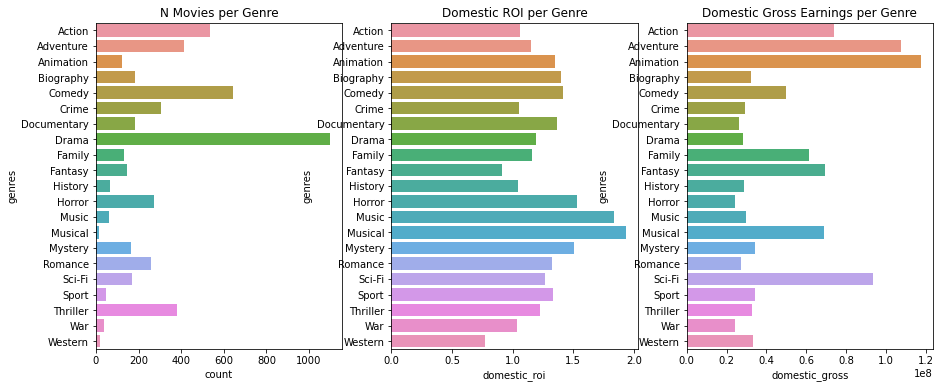

In [12]:
# plot genre parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# number of movies per genre
sns.barplot(ax=axes[0], data=genre_roi, y="genres", x="count")
axes[0].set_title('N Movies per Genre')

# domestic roi per genre
sns.barplot(ax=axes[1], data=genre_roi, y="genres", x="domestic_roi")
axes[1].set_title('Domestic ROI per Genre')

# domestic roi per genre
sns.barplot(ax=axes[2], data=genre_roi, y="genres", x="domestic_gross")
axes[2].set_title('Domestic Gross Earnings per Genre')

plt.show()

#### ROI plot per genre
plot the average budget on the x axis and average domestic gross earnings on the y axis
include a y=x line to represent an ROI=1

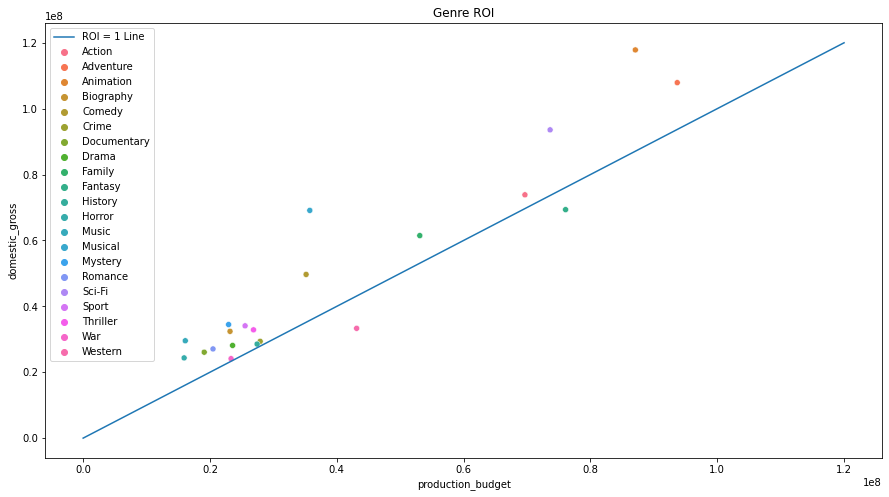

In [13]:
# plot genre parameters
fig, axes = plt.subplots(figsize=(15, 8))

# number of movies per genre
sns.scatterplot(data=genre_roi, x="production_budget", y="domestic_gross", hue="genres")
axes.set_title('Genre ROI')

# add ROI = 1 line
plt.plot([0, 120000000], [0, 120000000], '-', label='ROI = 1 Line')

plt.legend()

- high risk high reward genres: animation, sci-fi
- low risk low reward genres: sport, biography, horror
- middle ground: family, action

## organize by release month

Group the data by the relase month column created during data cleaning. 

get the sum and mean aggregations, then combine them so as to include average gross earnings and budget data as well as the total data for that month.

In [14]:
month_sums = budgets_basics.groupby('release_month').sum()
month_sums.to_csv('data/month_sums.csv')

month_means = budgets_basics.groupby('release_month').mean()
month_means.to_csv('data/month_means.csv')

# reset index
month_sums = month_sums.reset_index()
month_means = month_means.reset_index()

### Month visualizations
plot the number of movies per month, the average domestic ROI per month, and the average domestic gross earnings per month

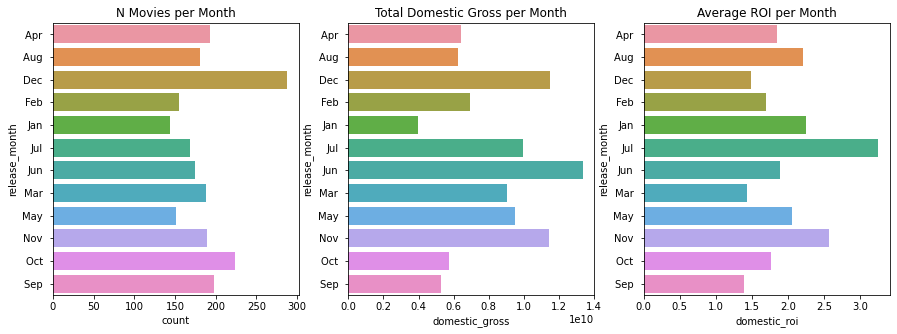

In [15]:
# plot stats per month
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# number of movies released per month
sns.barplot(ax = axes[0], data=month_sums, y="release_month", x="count")
axes[0].set_title('N Movies per Month')

# total domestic gross per month
sns.barplot(ax = axes[1], data=month_sums, y="release_month", x="domestic_gross")
axes[1].set_title('Total Domestic Gross per Month')

# average ROI of movies released per month
sns.barplot(ax = axes[2], data=month_means, y="release_month", x="domestic_roi")
axes[2].set_title('Average ROI per Month')

plt.show()

- Month with the most movies: December
- Month with the most earings: June

## Combine directors table and budgets table

Combine the directors data set and the budgets data set, using the movie title as the common column

In [16]:
budgets_directors = budgets.merge(director_table, left_on='title', right_on='title')
budgets_directors = budgets_directors.set_index('title')
budgets_directors.to_csv('data/budgets_directors.csv')

## Group by director and get average domestic and worldwide ROI

Group the table by the directors name

get their aggreate sum, mean and count data and combine into a table to get their total numbers of movies, average and total budgets and earnings, and their average ratings

In [17]:
director_roi = budgets_directors.groupby('primary_name').mean()
director_roi_count = budgets_directors.groupby('primary_name').count()
director_row_sum = budgets_directors.groupby('primary_name').sum()

# combine tables
director_roi['count'] = director_roi_count['averagerating']
director_roi['total_production_budget'] = director_row_sum['production_budget']
director_roi['total_domestic_gross'] = director_row_sum['domestic_gross']
director_roi['total_worldwide_gross'] = director_row_sum['worldwide_gross']


# remove rows with 0 gross earnings for bother domestic and worldwide
director_roi = director_roi[(director_roi['domestic_gross'] >= 1000000) & (director_roi['worldwide_gross'] >= 1000000)]

director_roi.to_csv('data/director_roi.csv')

director_roi.head()

,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,averagerating,numvotes,count,total_production_budget,total_domestic_gross,total_worldwide_gross
primary_name,,,,,,,,,,,
Aaron Seltzer,20000000.0,36661504.0,81424988.0,1.833075,4.071249,3.4,43984.0,1,20000000,36661504,81424988
Aash Aaron,3500000.0,12600000.0,12600000.0,3.600000,3.600000,8.1,16.0,1,3500000,12600000,12600000
Aashiq Abu,75000000.0,14010690.0,30626690.0,0.186809,0.408356,8.6,372.0,1,75000000,14010690,30626690
Abby Kohn,32000000.0,48795601.0,91553797.0,1.524863,2.861056,5.4,39936.0,1,32000000,48795601,91553797
Abhijit Guha,85000000.0,85900357.5,247044307.0,1.071387,3.007657,6.2,72.0,2,170000000,171800715,494088614


Filter the table to only include 

    - directors with average ratings above 7 (highly rated)
    - budgets between 1M and 100M (reasonable budgets)
    - at least 3 movie credits (experienced)

In [18]:
# sort top to bottom by domestic roi
director_roi_sorted = director_roi.sort_values('domestic_roi', ascending=False)

# restrict to directors with reasonable budgetes (between 1M and 100M)
director_high_budgets = director_roi_sorted[(director_roi_sorted['production_budget'] >= 1000000)]
director_reasonable_budgets = director_high_budgets[(director_high_budgets['production_budget'] <= 100000000)]

# restrict to directors with averag ratings above 7
high_rated_directors = director_reasonable_budgets[(director_reasonable_budgets['averagerating'] > 7)]

# restrict to directors with more than 2 movies, to get experienced directors
experienced_directors = high_rated_directors[(high_rated_directors['count'] > 2)]

experienced_directors.to_csv('data/experienced_directors.csv')

In [19]:
experienced_directors_sorted = experienced_directors.sort_values('averagerating', ascending=False)

In [20]:
# reset index
experienced_directors_sorted = experienced_directors_sorted.reset_index()
experienced_directors_sorted.head()

,primary_name,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,averagerating,numvotes,count,total_production_budget,total_domestic_gross,total_worldwide_gross
0,Dario Pleic,4.750000e+07,5.913765e+07,1.435970e+08,0.465154,30.851850,8.400000,32.000000,3,142500000,177412943,430791064
1,Denis Villeneuve,6.296000e+07,6.146980e+07,1.352639e+08,1.306876,2.672155,7.980000,374140.200000,5,314800000,307348989,676319696
2,Damien Chazelle,2.776667e+07,6.971012e+07,1.901747e+08,4.090436,11.626585,7.966667,390998.333333,3,83300000,209130354,570524025
3,David Fincher,6.366667e+07,1.224152e+08,2.776211e+08,2.104471,4.774950,7.866667,572583.333333,3,191000000,367245676,832863294
4,Alejandro G. Iñárritu,6.266667e+07,7.702658e+07,2.202803e+08,1.286095,3.462407,7.733333,406997.333333,3,188000000,231079729,660840920


### Director Visualizations

plot the average director domestic ROI, average directory rating, and average director produciton budget

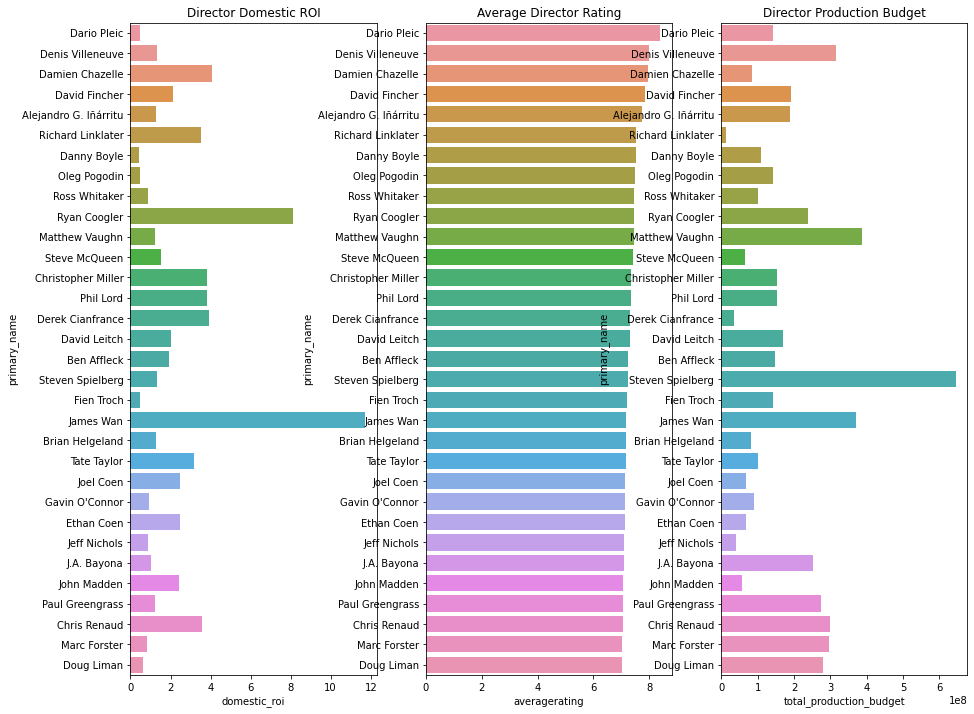

In [21]:
# plot stats per month
fig, axes = plt.subplots(1, 3, figsize=(15, 12))

# number of movies released per month
sns.barplot(ax = axes[0], data=experienced_directors_sorted, y="primary_name", x="domestic_roi")
axes[0].set_title('Director Domestic ROI')

# average ROI of movies released per month
sns.barplot(ax = axes[1], data=experienced_directors_sorted, y="primary_name", x="averagerating")
axes[1].set_title('Average Director Rating')

# total domestic gross per month
sns.barplot(ax = axes[2], data=experienced_directors_sorted, y="primary_name", x="total_production_budget")
axes[2].set_title('Director Production Budget')

plt.show()

Damien Chazelle, Ryan Coogler, Christopher Miller & Phil Lord, and James Wan all stand out as directors that are well known, make good movies, and have a high ROI. 

## Director Freshness Ratings

Get the average Rotten Tomatoes rating for directors with more than 2 movie credits

In [38]:
# obtain the average fresh rating for each movie in the rotten tomatoes db, as well as the number of reviews
avg_fresh_rating_df = reviews.groupby('id').mean()
sum_fresh_rating_df = reviews.groupby('id').count()
avg_fresh_rating_df['n_reviews'] = sum_fresh_rating_df['fresh_rating']

# combine the freshness rating with the rotten tomatoes movie info db
rt_movie_fresh_df = movie_info.merge(avg_fresh_rating_df, left_on='id', right_on='id')
rt_movie_fresh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114 entries, 0 to 1113
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1114 non-null   int64  
 1   rating        1114 non-null   object 
 2   genre         1114 non-null   object 
 3   director      997 non-null    object 
 4   theater_date  986 non-null    object 
 5   box_office    299 non-null    float64
 6   studio        412 non-null    object 
 7   top_critic    1114 non-null   float64
 8   fresh_rating  1114 non-null   float64
 9   n_reviews     1114 non-null   int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 95.7+ KB


In [46]:
# group by directors to get the average freshness rating for each director
fresh_directors = rt_movie_fresh_df.groupby('director').mean()
sum_fresh_directors = rt_movie_fresh_df.groupby('director').count()
fresh_directors['n_reviews'] = sum_fresh_directors['fresh_rating']
fresh_directors

,id,box_office,top_critic,fresh_rating,n_reviews
director,,,,,
Abel Ferrara,504.0,NaN,0.066667,0.300000,2
Adam Ravetch|Sarah Robertson,596.0,598103.0,0.289474,0.644737,1
Adam Shankman,491.0,82468131.0,0.272727,0.054545,1
Adrian Lyne,958.0,NaN,0.148579,0.541021,2
Akira Kurosawa,1703.0,NaN,0.157895,0.894737,1
...,...,...,...,...,...
Yoav Shamir,1508.0,NaN,0.500000,0.857143,1
Yoji Yamada,781.0,NaN,0.187500,0.812500,1
Youssef Delara,1334.0,320676.0,0.000000,0.666667,1


In [54]:
# filter out directors with less than 3 movies
fresh_experienced_directors = fresh_directors[(fresh_directors['n_reviews'] > 2)]

# sort by number of reviews
fresh_experienced_directors_sorted_by_n = fresh_experienced_directors.sort_values(by='fresh_rating', axis=0, ascending=False)
fresh_experienced_directors_sorted_by_n

# reset the index
fresh_experienced_directors_sorted_by_n = fresh_experienced_directors_sorted_by_n.reset_index()

Text(0.5, 1.0, 'Director Freshness Rating')

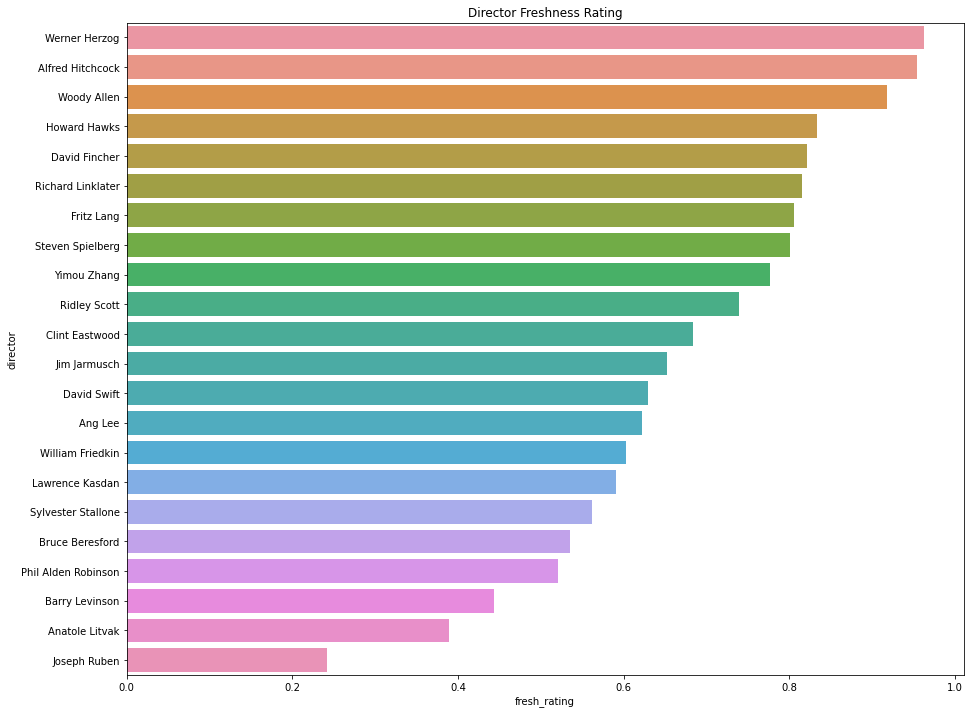

In [59]:
# plot stats per month
fig, axes = plt.subplots(figsize=(15, 12))

# number of movies released per month
sns.barplot(data=fresh_experienced_directors_sorted_by_n, y="director", x="fresh_rating")
axes.set_title('Director Freshness Rating')

# Linear Regression

The goal is to find genres increasing in popularity

null hypothesis: the change in domestic gross earnings is not correlated to the year

alternate hypothesis: the change in domestic gross earnings is correlated to the year (increasing or decreasing in popularity)


The following linear regressions are for the genres that show the most likelyhood to increase in popularity: 
    
    - Sci-Fi
    - Aciton
    - Fantasy
    - Musical
    - Sport
    
Linear regressions for genres that show the most lieklyhood to decrease in popularity are also shown: 

    - War
    - Horror
    - Drama

Create a function to perform the linear regression for a specific genre name and produce the visualizations.

In [22]:
def lin_reg(genre_name):
    
    # isolate the data for the genre specified
    genre = split_genres[split_genres['genres'] == genre_name]
    genre = genre[genre['release_year'] >= 1990]
    genre_year = genre.groupby('release_year', as_index=False).mean()
    genre_year_sum = genre.groupby('release_year').sum()
    genre_year['count'] = genre_year_sum['count']
    
    # manual calculations
    rho = np.corrcoef(genre_year['release_year'], genre_year['domestic_gross'])[0][1]
    s_y = genre_year['domestic_gross'].std()
    s_x = genre_year['release_year'].std()
    m = rho * s_y / s_x

    mean_y = genre_year['domestic_gross'].mean()
    mean_x = genre_year['release_year'].mean()
    c = mean_y - m * mean_x

    print(f"Our regression line is: y = {round(m, 5)}x + {round(c, 5)}")

    # regression with statsmodels
    model = sm.OLS(endog=genre_year.domestic_gross, exog=sm.add_constant(genre_year.release_year))
    results = model.fit()

    # plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.regplot(x='release_year', y='domestic_gross', data=genre_year, ax=axes[0])
    axes[0].set_title(f'{genre_name} Domestic Growth Linear Regression')

    sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True, ax=axes[1])
    axes[1].set_title('residuals')

    plt.show()
    
    return results


## Sci-Fi Domestic Gross

Our regression line is: y = 4619352.75155x + -9213369324.60271


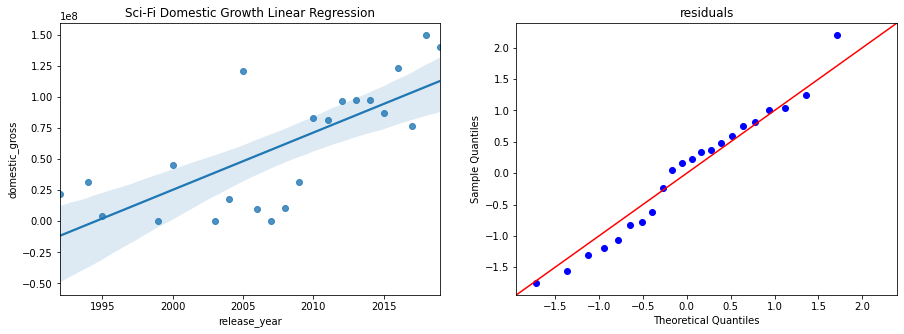

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     23.56
Date:                Tue, 05 Sep 2023   Prob (F-statistic):           9.62e-05
Time:                        14:18:17   Log-Likelihood:                -412.09
No. Observations:                  22   AIC:                             828.2
Df Residuals:                      20   BIC:                             830.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.213e+09   1.91e+09     -4.823      0.000   -1.32e+10   -5.23e+09
release_year  4.619e+06   9.52e+05      4.854      0.000    2.63e+06     6.6e+06
==============================================================================
Omnibus:                        0.241   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.887   Jarque-Bera (JB):                0.433
Skew:                           0.032   Prob(JB):                        0.806
Kurtosis:                       2.316   Cond. No.                     5.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
sci_fi_results = lin_reg('Sci-Fi')
sci_fi_results.summary()

### Interpretation: 

    P: <<0.05 - statistically significant
    Coef: 4.619e+06 increase per year
    R2: 54% of variation is due to the year
    F-stat: 23.56


## Action - Domestic Gross

Our regression line is: y = 2602537.69892x + -5167241401.43695


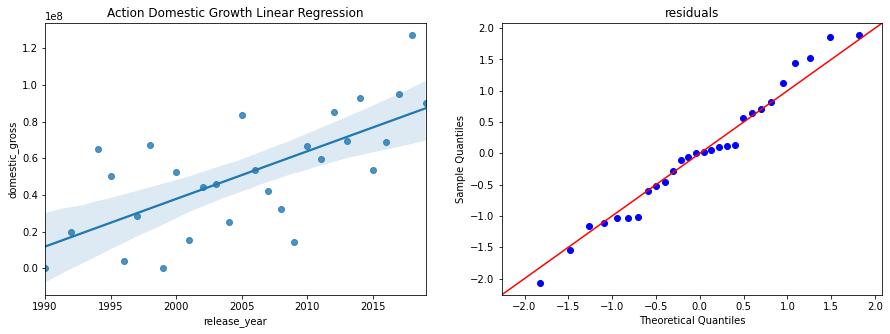

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     23.27
Date:                Tue, 05 Sep 2023   Prob (F-statistic):           5.35e-05
Time:                        14:18:21   Log-Likelihood:                -514.02
No. Observations:                  28   AIC:                             1032.
Df Residuals:                      26   BIC:                             1035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.167e+09   1.08e+09     -4.776      0.000   -7.39e+09   -2.94e+09
release_year  2.603e+06    5.4e+05      4.824      0.000    1.49e+06    3.71e+06
==============================================================================
Omnibus:                        0.266   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.875   Jarque-Bera (JB):                0.454
Skew:                           0.116   Prob(JB):                        0.797
Kurtosis:                       2.420   Cond. No.                     4.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
action_results = lin_reg('Action')
action_results.summary()

### Interpretation: 

    P: <<0.05 - statistically significant
    Coef: 2.603e+06 increase per year
    R2: 47% of variation is due to the year
    F-stat: 23.27

## Fantasy Domestic Gross

Our regression line is: y = 3146972.30881x + -6271392442.53548


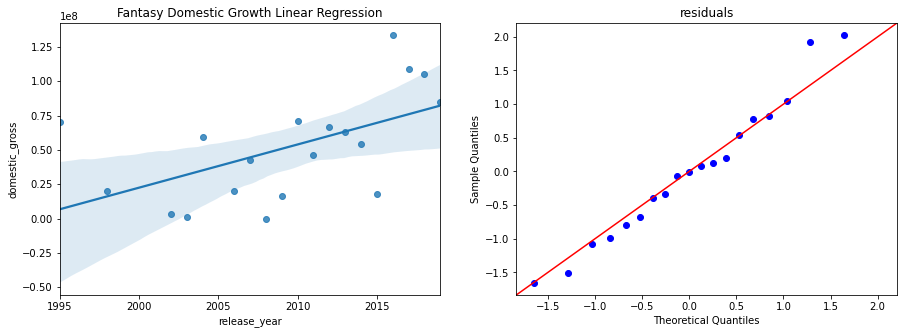

/Users/abigailcampbell/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     7.358
Date:                Tue, 05 Sep 2023   Prob (F-statistic):             0.0148
Time:                        14:18:23   Log-Likelihood:                -355.01
No. Observations:                  19   AIC:                             714.0
Df Residuals:                      17   BIC:                             715.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.271e+09   2.33e+09     -2.690      0.015   -1.12e+10   -1.35e+09
release_year  3.147e+06   1.16e+06      2.713      0.015    6.99e+05    5.59e+06
==============================================================================
Omnibus:                        0.565   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.754   Jarque-Bera (JB):                0.553
Skew:                           0.344   Prob(JB):                        0.758
Kurtosis:                       2.526   Cond. No.                     6.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
fantasy_results = lin_reg('Fantasy')
fantasy_results.summary()

### Interpretation: 

    P: 0.015 - statistically significant (though barely)
    Coef: 3.147e+06 increase per year
    R2: 30% of variation is due to the year
    F-stat: 7.36

## Musical Domestic Gross

Our regression line is: y = 9469200.52815x + -18978983944.94619


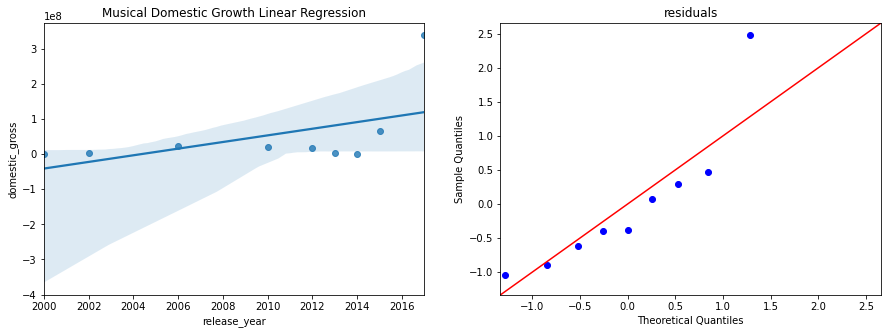

/Users/abigailcampbell/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     2.530
Date:                Tue, 05 Sep 2023   Prob (F-statistic):              0.156
Time:                        14:18:27   Log-Likelihood:                -177.44
No. Observations:                   9   AIC:                             358.9
Df Residuals:                       7   BIC:                             359.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.898e+10    1.2e+10     -1.586      0.157   -4.73e+10    9.32e+09
release_year  9.469e+06   5.95e+06      1.591      0.156   -4.61e+06    2.35e+07
==============================================================================
Omnibus:                       10.270   Durbin-Watson:                   1.010
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                3.954
Skew:                           1.462   Prob(JB):                        0.139
Kurtosis:                       4.413   Cond. No.                     7.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
musical_results = lin_reg('Musical')
musical_results.summary()

### Interpretation: 

    P: 0.156 - not statistically significant
    Coef: 9.469e+06 increase per year
    R2: 26.5% of variation is due to the year
    F-stat: 2.53

## Sport Domestic Gross


Our regression line is: y = 2576014.49845x + -5138391749.45988


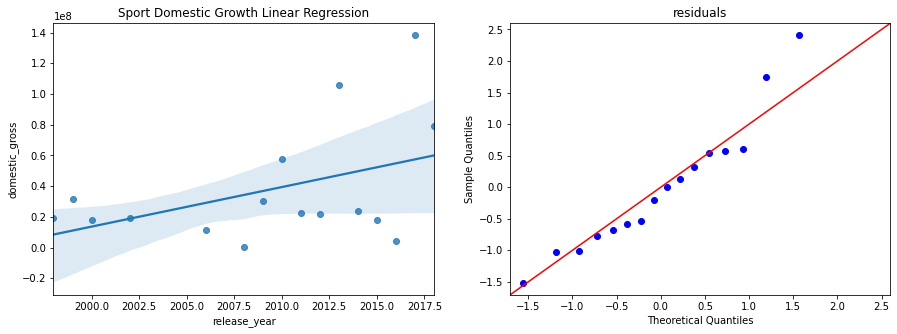

/Users/abigailcampbell/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     3.323
Date:                Tue, 05 Sep 2023   Prob (F-statistic):             0.0897
Time:                        14:18:30   Log-Likelihood:                -299.97
No. Observations:                  16   AIC:                             603.9
Df Residuals:                      14   BIC:                             605.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.138e+09   2.84e+09     -1.810      0.092   -1.12e+10    9.52e+08
release_year  2.576e+06   1.41e+06      1.823      0.090   -4.55e+05    5.61e+06
==============================================================================
Omnibus:                        3.406   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                1.815
Skew:                           0.819   Prob(JB):                        0.404
Kurtosis:                       3.196   Cond. No.                     6.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
sport_results = lin_reg('Sport')
sport_results.summary()

### Interpretation: 

    P: 0.092 - not statistically significant
    Coef: 2.576e+06 increase per year
    R2: 19.2% of variation is due to the year
    F-stat: 3.32

## Drama Domestic Gross

Our regression line is: y = -994884.33769x + 2027415506.61163


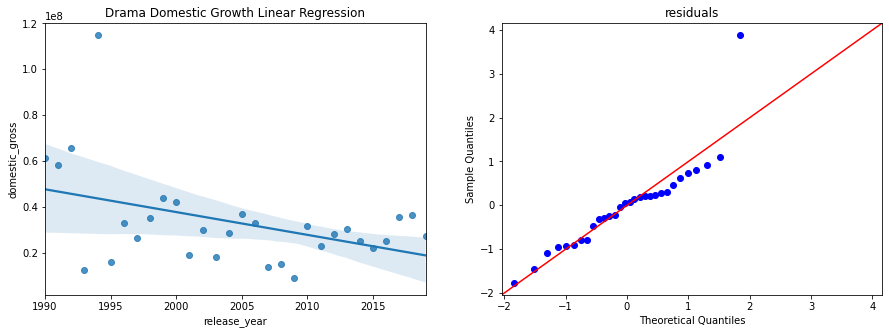

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     6.161
Date:                Tue, 05 Sep 2023   Prob (F-statistic):             0.0193
Time:                        14:18:33   Log-Likelihood:                -544.34
No. Observations:                  30   AIC:                             1093.
Df Residuals:                      28   BIC:                             1095.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.027e+09   8.03e+08      2.523      0.018    3.82e+08    3.67e+09
release_year -9.949e+05   4.01e+05     -2.482      0.019   -1.82e+06   -1.74e+05
==============================================================================
Omnibus:                       23.252   Durbin-Watson:                   2.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.213
Skew:                           1.608   Prob(JB):                     5.60e-11
Kurtosis:                       8.238   Cond. No.                     4.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
drama_results = lin_reg('Drama')
drama_results.summary()

### Interpretation: 

    P: 0.018 - statistically significant, but barely
    Coef: -9.949e+05 decrease per year
    R2: 18% of variation is due to the year
    F-stat: 6.16

## Horror Domestic Gross

Our regression line is: y = -622878.29095x + 1279926497.33973


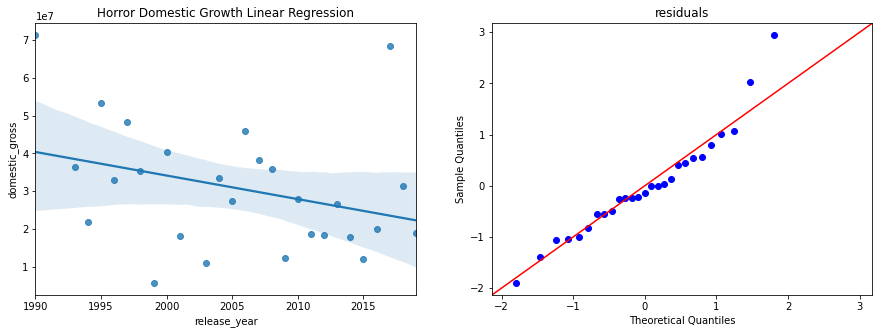

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     2.891
Date:                Tue, 05 Sep 2023   Prob (F-statistic):              0.101
Time:                        14:18:36   Log-Likelihood:                -484.90
No. Observations:                  27   AIC:                             973.8
Df Residuals:                      25   BIC:                             976.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.28e+09   7.35e+08      1.742      0.094   -2.33e+08    2.79e+09
release_year -6.229e+05   3.66e+05     -1.700      0.101   -1.38e+06    1.32e+05
==============================================================================
Omnibus:                        6.929   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                5.008
Skew:                           0.849   Prob(JB):                       0.0818
Kurtosis:                       4.252   Cond. No.                     4.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
horror_results = lin_reg('Horror')
horror_results.summary()

### Interpretation: 

    P: 0.094 - not statistically significant
    Coef: -6.229e+06 decrease per year
    R2: 10.4% of variation is due to the year
    F-stat: 2.89

## War Domestic Gross

Our regression line is: y = -2619716.57887x + 5288569324.92254


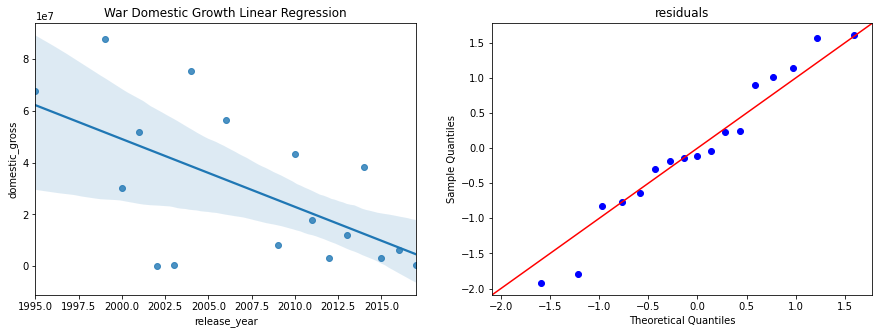

/Users/abigailcampbell/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     8.413
Date:                Tue, 05 Sep 2023   Prob (F-statistic):             0.0110
Time:                        14:18:39   Log-Likelihood:                -312.16
No. Observations:                  17   AIC:                             628.3
Df Residuals:                      15   BIC:                             630.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.289e+09   1.81e+09      2.917      0.011    1.42e+09    9.15e+09
release_year  -2.62e+06   9.03e+05     -2.900      0.011   -4.54e+06   -6.95e+05
==============================================================================
Omnibus:                        0.149   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.325
Skew:                          -0.165   Prob(JB):                        0.850
Kurtosis:                       2.408   Cond. No.                     6.17e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
war_results = lin_reg('War')
war_results.summary()

### Interpretation: 

    P: 0.011 - statistically significant, but barely
    Coef: -2.62e+06 decrease per year
    R2: 35.9% of variation is due to the year
    F-stat: 8.413